# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D,LSTM, TimeDistributed, GlobalAveragePooling3D,Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
# Setting up path of train and validation data 
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
#Initiating Parameters 
batch_size = 16
total_frames = 30
num_frames = 15
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.5 


In [5]:
# Creating Function to resize and crop image { Resizes an image while preserving the aspect ratio and then center-crops it}, Function will be used in Generator

def resize_crop_image(image):
    # Original dimensions
    h, w = image.shape[:2]
    
    # Aspect ratio calculation
    aspect_ratio = w / h
    
    # Define target aspect ratio
    target_aspect_ratio = image_width / image_height
    
    # Crop if the aspect ratios do not match
    if aspect_ratio > target_aspect_ratio:
        # Too wide: Crop width
        new_w = int(h * target_aspect_ratio)
        start_x = (w - new_w) // 2
        image = image[:, start_x:start_x + new_w]
    else:
        # Too tall: Crop height
        new_h = int(w / target_aspect_ratio)
        start_y = (h - new_h) // 2
        image = image[start_y:start_y + new_h, :]

    # Resize to final dimensions
    image = resize(image, (image_height, image_width), anti_aliasing=True)

    return image

In [6]:
# Creating Function to view images after resize is done
def show_resize_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))

        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        
        plt.imshow(image)
        plt.title('Modified')

        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')

    plt.show()

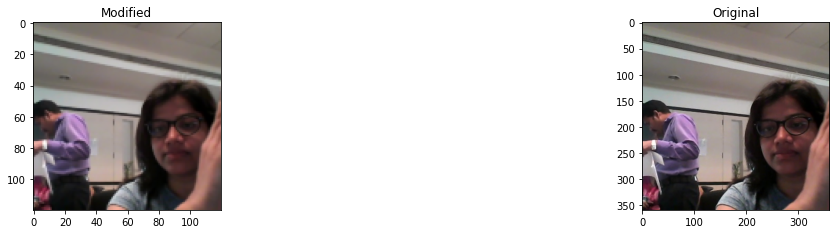

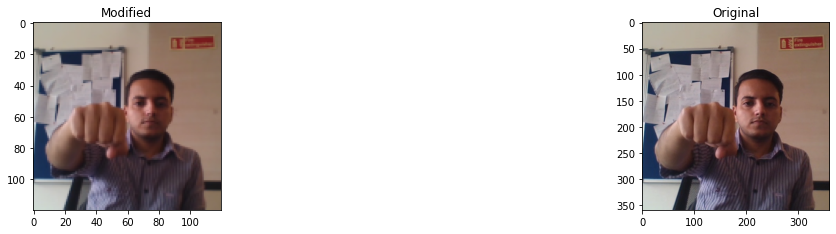

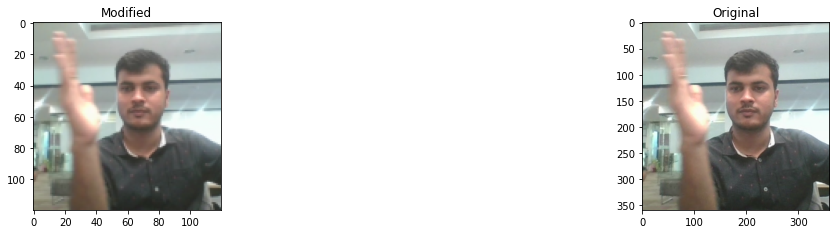

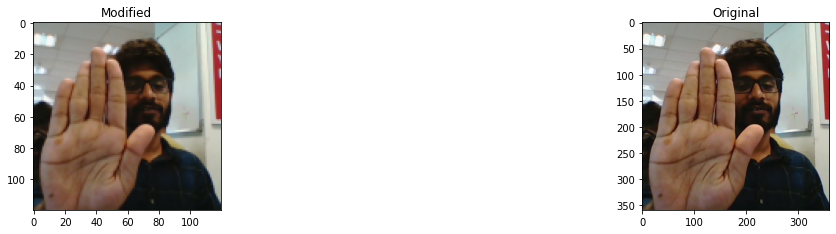

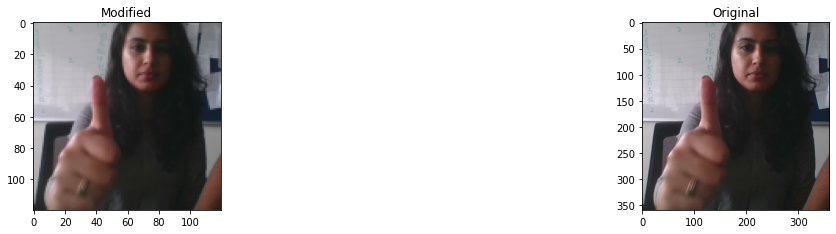

In [7]:
# Path of sample images to view
paths = ["/home/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_40_26_Pro_Thumbs Down_new/WIN_20180907_15_40_26_Pro_00009.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_43_00_Pro_00019.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_48_01_Pro_Stop Gesture_new/WIN_20180907_15_48_01_Pro_00046.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_59_28_Pro_Thumbs Up_new/WIN_20180907_15_59_28_Pro_00036.png"]

show_resize_image(paths)

In [8]:
def generator(source_path, folder_list, batch_size):
    print('Source path =', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle data
        num_batches = len(folder_list) // batch_size  # Number of full batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3), dtype=np.float32) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures), dtype=np.float32) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                folder_name, _, label = t[folder + (batch * batch_size)].strip().split(';')
                label = int(label)  # Convert label to integer
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))  # read all the images in the folder and Sort to maintain order

                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    if item >= len(imgs):  # Ensure index is within bounds
                        continue  
                    
                    image_path = os.path.join(source_path, folder_name, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    image = resize_crop_image(image) #Resizing image using function resize_crop_image
                    
                    batch_data[folder, idx] = image / 255  # Normalize all channels
                    
                batch_labels[folder, label] = 1  # One-hot encoding

            yield batch_data, batch_labels  # Yield batch data & labels

        # Handling remaining data (if any)
        remaining = len(folder_list) % batch_size
        if remaining > 0:
            batch_data = np.zeros((remaining, len(img_idx), image_height, image_width, 3), dtype=np.float32) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining, gestures), dtype=np.float32)  # batch_labels is the one hot representation of the output

            for folder in range(remaining):
                folder_name, _, label = t[num_batches * batch_size + folder].strip().split(';')
                label = int(label)
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))

                for idx, item in enumerate(img_idx):
                    if item >= len(imgs):  # Ensure index is within bounds
                        continue  
                    
                    image_path = os.path.join(source_path, folder_name, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    image = resize_crop_image(image) #Resizing image using function resize_crop_image

                    batch_data[folder, idx] = image / 255  # Normalize all channels

                batch_labels[folder, label] = 1  # One-hot encoding

            yield batch_data, batch_labels # Yield batch data & labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Experiment 1
- Develop a CNN model comprising 4 convolutional layers and 2 dense layers, including a dropout rate of 0.5, utilizing 'adam' as the optimizer.
- Batch Size: 16
- Image Dimensions: 120 x 120 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [10]:
#write your model here
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

2025-02-01 10:03:54.046362: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-01 10:03:54.046427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 16)    6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 16
Epoch 1/25


2025-02-01 10:03:58.830468: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.8621 - categorical_accuracy: 0.2262Source path = /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 1.59867, saving model to model_init_2025-02-0110_03_52.432780/model-00001-1.86210-0.22624-1.59867-0.39000.keras
42/42 [==============================] - 84s 2s/step - loss: 1.8621 - categorical_accuracy: 0.2262 - val_loss: 1.5987 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.5534 - categorical_accuracy: 0.2896
Epoch 00002: val_loss did not improve from 1.59867
42/42 [==============================] - 74s 2s/step - loss: 1.5534 - categorical_accuracy: 0.2896 - val_loss: 1.6558 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.5656 - categorical_accuracy: 0.2715
Epoch 00003: val_loss did not improve from 1.59867

Epoch 00003: ReduceLROnPlateau reducing

Training Accuracy: 31.52%
Validation Accuracy: 46.00% 



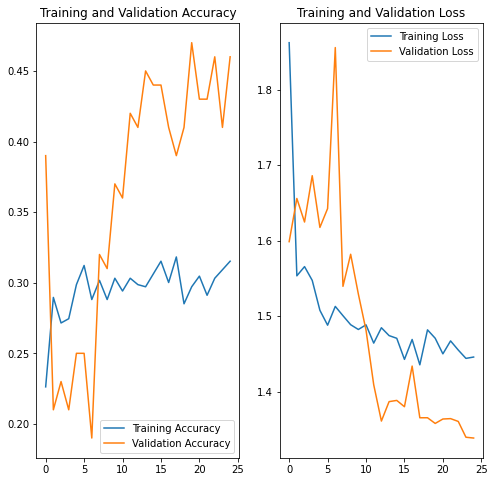

In [16]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 1
- Model Underfitting: The model is underfitting, resulting in very low training accuracy.
- Fluctuating Accuracy: Both training and validation accuracy fluctuate significantly.
- Accuracy Discrepancy: There is a notable difference between training and validation accuracy, indicating a potential generalization issue.

## Experiment 2
- Lower image dimensions to 60 x 60 pixels while maintaining all other parameters.
- Model Structure: 4 convolutional layers and 2 dense layers, with a dropout rate of 0.5, using 'adam' as the optimizer.
- Batch Size: 16
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [17]:
batch_size = 16
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
dropout_rate = 0.5 

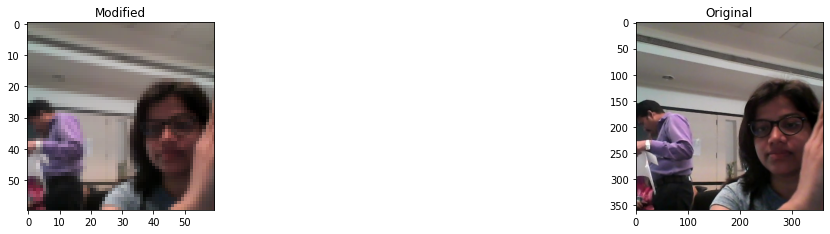

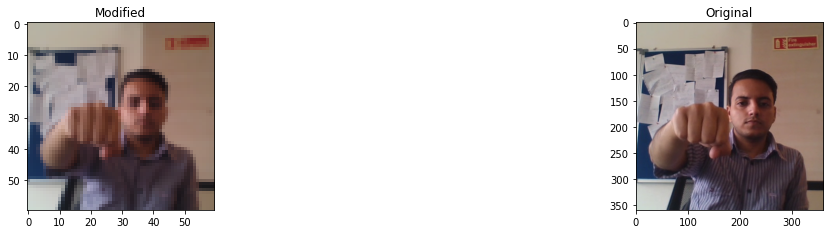

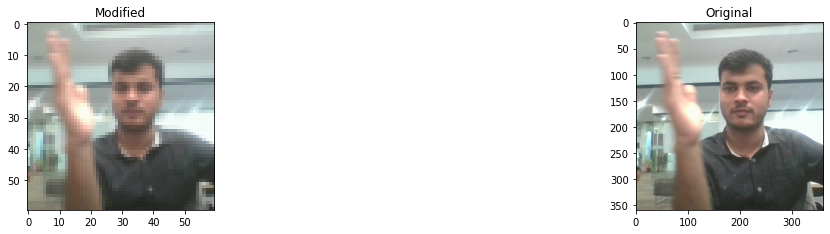

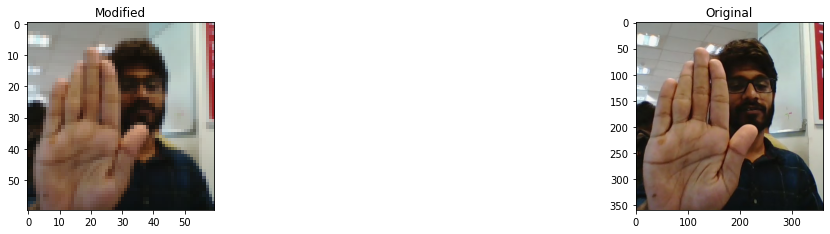

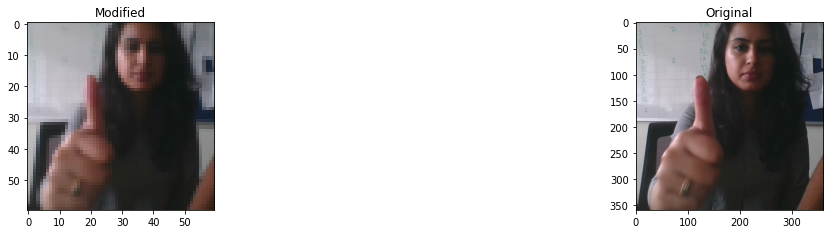

In [18]:
show_resize_image(paths)

In [19]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [20]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_4 (Batc  (None, 15, 60, 60, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 30, 30, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_5 (Batc  (None, 7, 30, 30, 16)   

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.7904 - categorical_accuracy: 0.2323Source path = /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 1.60604, saving model to model_exp2_2025-02-0110_03_52.432780/model-00001-1.79040-0.23228-1.60604-0.20000.keras
42/42 [==============================] - 82s 2s/step - loss: 1.7904 - categorical_accuracy: 0.2323 - val_loss: 1.6060 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.5298 - categorical_accuracy: 0.2821
Epoch 00002: val_loss did not improve from 1.60604
42/42 [==============================] - 80s 2s/step - loss: 1.5298 - categorical_accuracy: 0.2821 - val_loss: 1.6202 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.4389 - categorical_accuracy: 0.3439
Epoch 00003: v

Training Accuracy: 86.58%
Validation Accuracy: 89.00% 



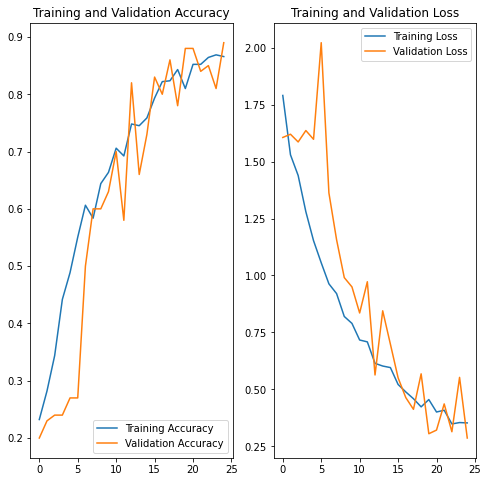

In [25]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 2
- Improved Training Accuracy: There is a noticeable improvement in training accuracy.
- Model Instability: The model remains unstable, causing some variability in performance.
- Higher Validation Accuracy: Validation accuracy surpasses training accuracy, which is unusual and could hint at potential issues with the training process or data.

## Experiment 3
- Lower the batch size to 8, keeping all other parameters the same as Experiment 2.
- Model Structure: 4 convolutional layers and 2 dense layers, with a dropout rate of 0.5, using 'adam' as the optimizer.
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [26]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.5 

In [27]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [28]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_8 (Batc  (None, 15, 60, 60, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 7, 30, 30, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_9 (Batc  (None, 7, 30, 30, 16)   

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7342 - categorical_accuracy: 0.2217Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.58926, saving model to model_exp3_2025-02-0110_03_52.432780/model-00001-1.73418-0.22172-1.58926-0.34000.keras
83/83 [==============================] - 82s 997ms/step - loss: 1.7342 - categorical_accuracy: 0.2217 - val_loss: 1.5893 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5400 - categorical_accuracy: 0.2821
Epoch 00002: val_loss did not improve from 1.58926
83/83 [==============================] - 81s 984ms/step - loss: 1.5400 - categorical_accuracy: 0.2821 - val_loss: 1.7980 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.4495 - categorical_accuracy: 0.3469
Epoch 0000

Training Accuracy: 67.72%
Validation Accuracy: 86.00% 



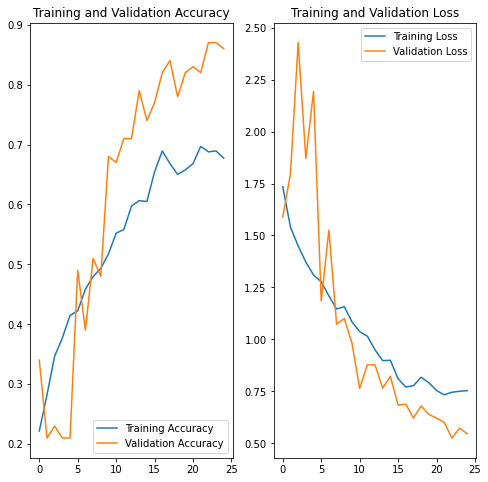

In [33]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 3
- Training accuracy has reduced
- Higher Validation Accuracy: Validation accuracy is still higher than training accuracy, indicating potential issues with model overfitting or data inconsistencies.
- High Training Time: The training process is taking a considerable amount of time, which could be a limiting factor.

### Experiment 4
- Lower the image dimensions to 30 x 30 pixels while maintaining all other parameters.
- Model Structure: 4 convolutional layers and 2 dense layers, with a dropout rate of 0.5, using 'adam' as the optimizer.
- Batch Size: 8
- Image Dimensions: 30 x 30 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [34]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 30 #reducing image size
image_width = 30
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.5 

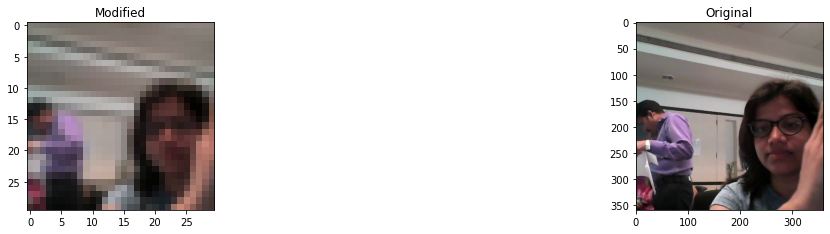

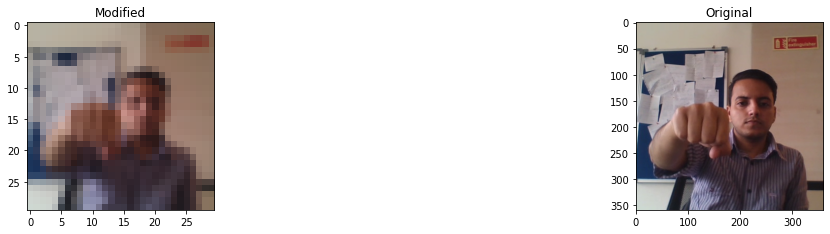

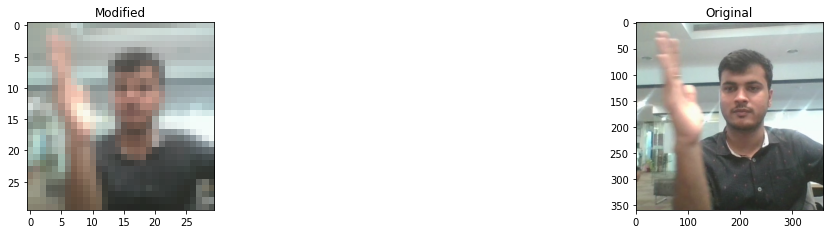

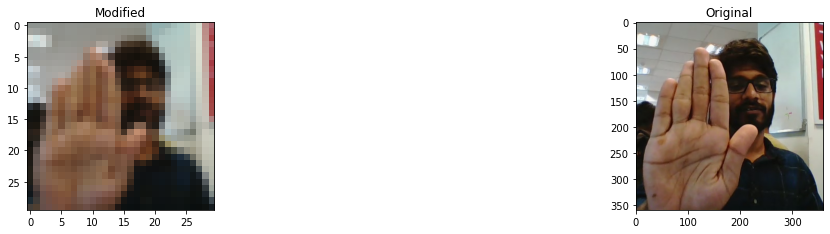

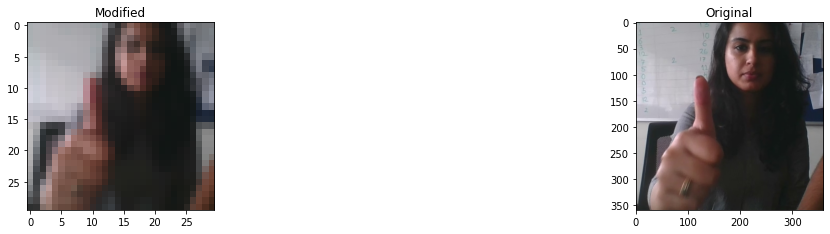

In [35]:
show_resize_image(paths)

In [36]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [37]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 30, 30, 8)     656       
                                                                 
 batch_normalization_12 (Bat  (None, 15, 30, 30, 8)    32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 30, 30, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 15, 15, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 15, 15, 16)     3472      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 15, 15, 16)   

In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7458 - categorical_accuracy: 0.2398Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.59914, saving model to model_exp4_2025-02-0110_03_52.432780/model-00001-1.74584-0.23982-1.59914-0.27000.keras
83/83 [==============================] - 116s 1s/step - loss: 1.7458 - categorical_accuracy: 0.2398 - val_loss: 1.5991 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5564 - categorical_accuracy: 0.3122
Epoch 00002: val_loss did not improve from 1.59914
83/83 [==============================] - 113s 1s/step - loss: 1.5564 - categorical_accuracy: 0.3122 - val_loss: 1.6145 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.4442 - categorical_accuracy: 0.3499
Epoch 00003: v

Training Accuracy: 87.93%
Validation Accuracy: 82.00% 



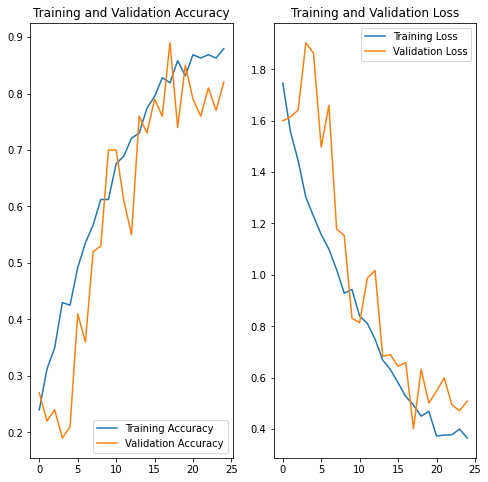

In [42]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 4
- Increased Accuracy: Training accuracy has imprived and validation accuracy although has reduced but it is in line with training accuracy.
- High Training Time: Training time continues to be substantial.
- Model Fluctuations: The model's performance fluctuates with each epoch, indicating potential instability.

### Experiment 5
- Decrease the number of frames to 10 and increase the image dimensions back to 60 x 60 pixels.
- Model Structure: 4 convolutional layers and 2 dense layers, with a dropout rate of 0.5, using 'adam' as the optimizer.
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 10
- Number of Epochs: 25

In [43]:
batch_size = 8
total_frames = 30
num_frames = 10 # reducing frame size
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.5 


In [44]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [45]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 10, 60, 60, 8)     656       
                                                                 
 batch_normalization_16 (Bat  (None, 10, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 10, 60, 60, 8)     0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 5, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 5, 30, 30, 16)     3472      
                                                                 
 batch_normalization_17 (Bat  (None, 5, 30, 30, 16)   

In [46]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [47]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.6949 - categorical_accuracy: 0.2443Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.63201, saving model to model_exp5_2025-02-0110_03_52.432780/model-00001-1.69492-0.24434-1.63201-0.22000.keras
83/83 [==============================] - 61s 730ms/step - loss: 1.6949 - categorical_accuracy: 0.2443 - val_loss: 1.6320 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.4766 - categorical_accuracy: 0.3379
Epoch 00002: val_loss did not improve from 1.63201
83/83 [==============================] - 55s 671ms/step - loss: 1.4766 - categorical_accuracy: 0.3379 - val_loss: 1.7306 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.3929 - categorical_accuracy: 0.4042
Epoch 0000

Training Accuracy: 81.75%
Validation Accuracy: 88.00% 



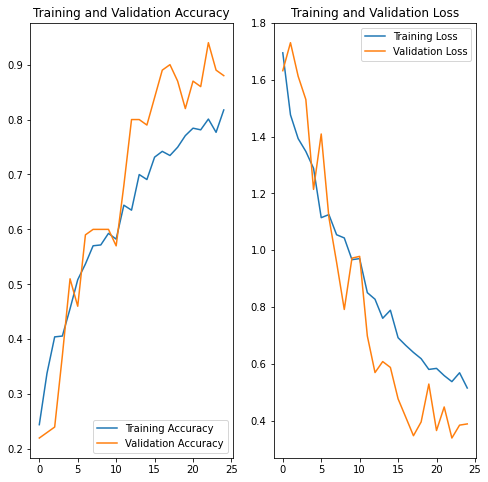

In [50]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 5
- Dropped Accuracy: Accuracy has decreased after reducing the frame size.
- Higher validation accuracy
- Model Fluctuations: The model continues to fluctuate, indicating instability

## Experiment 6
- Reduce model complexity by removing a CNN layer to optimize training time (resulting in a CNN model with 3 convolutional layers and 2 dense layers, with a dropout rate of 0.5, using 'adam' as the optimizer).
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [51]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.5 

In [52]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
#model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))  # Added layer
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [53]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_20 (Bat  (None, 15, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 7, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_21 (Bat  (None, 7, 30, 30, 16)   

In [54]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [55]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7829 - categorical_accuracy: 0.1976Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.60953, saving model to model_exp6_2025-02-0110_03_52.432780/model-00001-1.78295-0.19759-1.60953-0.22000.keras
83/83 [==============================] - 83s 1s/step - loss: 1.7829 - categorical_accuracy: 0.1976 - val_loss: 1.6095 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5772 - categorical_accuracy: 0.2459
Epoch 00002: val_loss did not improve from 1.60953
83/83 [==============================] - 81s 988ms/step - loss: 1.5772 - categorical_accuracy: 0.2459 - val_loss: 1.6118 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.5426 - categorical_accuracy: 0.2821
Epoch 00003: 

Training Accuracy: 54.45%
Validation Accuracy: 59.00% 



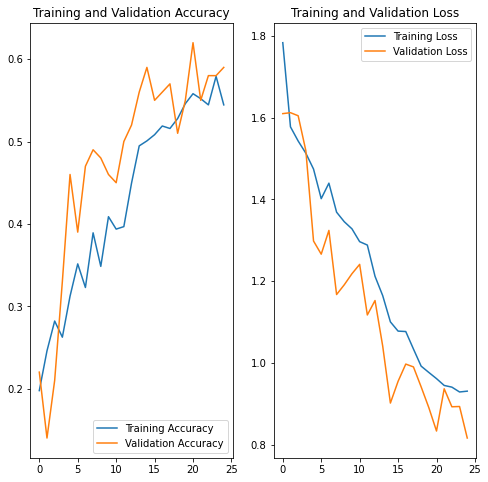

In [58]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 6
- Reduced Model Accuracy: There has been a significant decrease in model accuracy after dropping a layer.
- No Impact on Training Time: There is no notable impact on training time.

## Experiment 7
- Update the dropout rate to 0.4.
- Increase the number of neurons in the dense layer to 128 (resulting in a CNN model with 3 convolutional layers and 2 dense layers, using 'adam' as the optimizer).
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [59]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.4 

In [60]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
#model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))  # Added layer
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())

#Dense Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [61]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_23 (Bat  (None, 15, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 7, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_24 (Bat  (None, 7, 30, 30, 16)   

In [62]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [63]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [64]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [65]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8157 - categorical_accuracy: 0.2760Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.61382, saving model to model_exp7_2025-02-0110_03_52.432780/model-00001-1.81575-0.27602-1.61382-0.24000.keras
83/83 [==============================] - 81s 984ms/step - loss: 1.8157 - categorical_accuracy: 0.2760 - val_loss: 1.6138 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.4651 - categorical_accuracy: 0.3454
Epoch 00002: val_loss did not improve from 1.61382
83/83 [==============================] - 80s 980ms/step - loss: 1.4651 - categorical_accuracy: 0.3454 - val_loss: 1.7136 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.4118
Epoch 0000

Training Accuracy: 90.05%
Validation Accuracy: 88.00% 



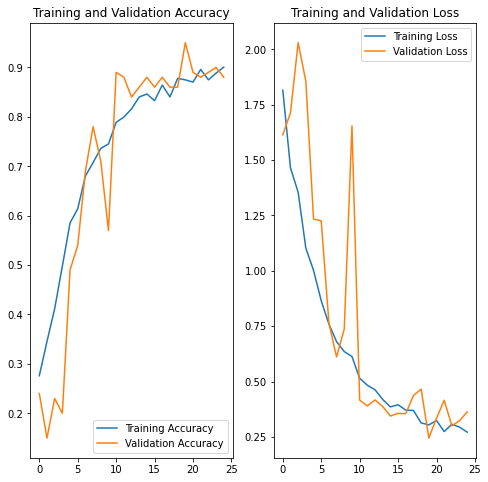

In [66]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 7
- Improved Performance: The model’s performance has improved.
- Significant Accuracy Increase: There is a notable improvement in accuracy.

## Experiment 8
- Add an LSTM layer to the model, resulting in a structure with 3 CNN layers, 1 LSTM layer, and 2 dense layers, with a dropout rate of 0.4, using 'adam' as the optimizer.
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [67]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

dropout_rate = 0.4 

In [68]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
#model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))  # Added layer
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(1,2,2)))

#model.add(Flatten())
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(dropout_rate))

#Dense Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [69]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_26 (Bat  (None, 15, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 7, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_27 (Conv3D)          (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_27 (Bat  (None, 7, 30, 30, 16)   

In [70]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [71]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [72]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [73]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.6598 - categorical_accuracy: 0.1885Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.60377, saving model to model_exp8_2025-02-0110_03_52.432780/model-00001-1.65984-0.18854-1.60377-0.21000.keras
83/83 [==============================] - 83s 980ms/step - loss: 1.6598 - categorical_accuracy: 0.1885 - val_loss: 1.6038 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6037 - categorical_accuracy: 0.2504
Epoch 00002: val_loss improved from 1.60377 to 1.59116, saving model to model_exp8_2025-02-0110_03_52.432780/model-00002-1.60367-0.25038-1.59116-0.22000.keras
83/83 [==============================] - 80s 977ms/step - loss: 1.6037 - categorical_accuracy: 0.2504 - val_loss: 1.5912 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/

Training Accuracy: 95.17%
Validation Accuracy: 92.00% 



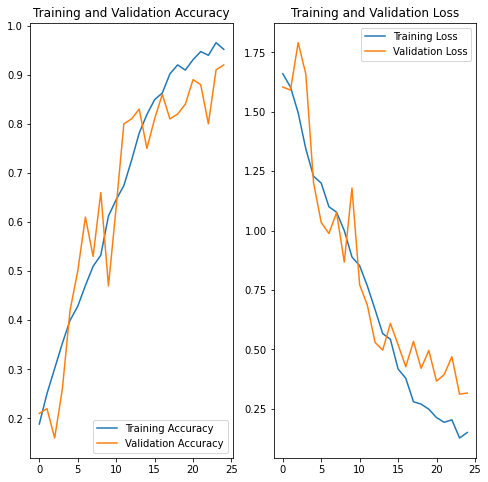

In [74]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 8
- Accuracy has improved significantly
- Reduced Accuracy Gap: The difference between training and validation accuracy has diminished.
- Gradual Learning: The model is demonstrating a gradual learning process.

## Experiment 9
- Reduce dropout rate to 0.3 and add L2 regularization with a factor of 0.005 (resulting in a model with 3 CNN layers, 1 LSTM layer, and 2 dense layers, using 'adam' as the optimizer).
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15
- Number of Epochs: 25

In [75]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

l2_regularization = 0.005  # L2 regularization factor
dropout_rate = 0.3 

In [76]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
#model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))  # Added layer
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(1,2,2)))

#model.add(Flatten())
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(dropout_rate))

#Dense Layer
model.add(Dense(128, activation='relu',kernel_regularizer=l2(l2_regularization)))
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu',kernel_regularizer=l2(l2_regularization)))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [77]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_29 (Bat  (None, 15, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 7, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_30 (Conv3D)          (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_30 (Bat  (None, 7, 30, 30, 16)   

In [78]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [79]:
model_name = 'model_exp9_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [81]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 2.4870 - categorical_accuracy: 0.1795Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 2.23621, saving model to model_exp9_2025-02-0110_03_52.432780/model-00001-2.48702-0.17949-2.23621-0.26000.keras
83/83 [==============================] - 82s 974ms/step - loss: 2.4870 - categorical_accuracy: 0.1795 - val_loss: 2.2362 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 2.1243 - categorical_accuracy: 0.2338
Epoch 00002: val_loss improved from 2.23621 to 1.99681, saving model to model_exp9_2025-02-0110_03_52.432780/model-00002-2.12426-0.23379-1.99681-0.35000.keras
83/83 [==============================] - 81s 986ms/step - loss: 2.1243 - categorical_accuracy: 0.2338 - val_loss: 1.9968 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/

Training Accuracy: 99.10%
Validation Accuracy: 96.00% 



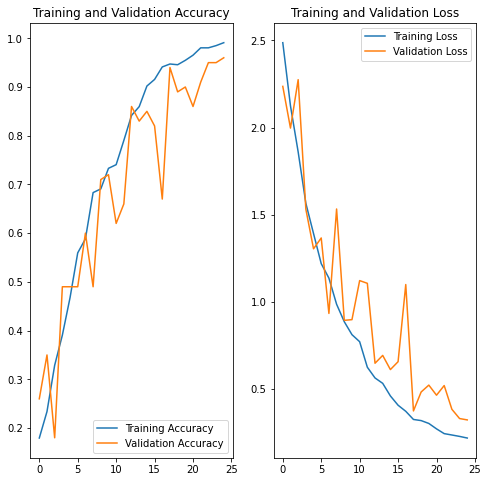

In [82]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][24]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][24]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 9
- Significant Improvement in Training Accuracy: Training accuracy has improved significantly after adding regularization.
- Stable Validation Accuracy: Validation accuracy has remained consistent.
- Both training and validation accuracy are in comparable range

## Experiment 10
- Increase the number of epochs to 40.
- Maintain the same model structure with 3 CNN layers, 1 LSTM layer, and 2 dense layers, with a dropout rate of 0.3 and L2 regularization of 0.005, using 'adam' as the optimizer.
- Batch Size: 8
- Image Dimensions: 60 x 60 pixels
- Frames Per Sample: 15



In [83]:
batch_size = 8
total_frames = 30
num_frames = 15
gestures = 5
image_height = 60
image_width = 60
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

l2_regularization = 0.005  # L2 regularization factor
dropout_rate = 0.3 

num_epochs = 40

In [84]:
model = Sequential()

# First Convolution Layer
model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Convolution Layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolution Layer
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Convolution Layer
#model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))  # Added layer
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(1,2,2)))

#model.add(Flatten())
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(dropout_rate))

#Dense Layer
model.add(Dense(128, activation='relu',kernel_regularizer=l2(l2_regularization)))
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu',kernel_regularizer=l2(l2_regularization)))
model.add(Dropout(dropout_rate))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [85]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 15, 60, 60, 8)     656       
                                                                 
 batch_normalization_32 (Bat  (None, 15, 60, 60, 8)    32        
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 15, 60, 60, 8)     0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 30, 30, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 7, 30, 30, 16)     3472      
                                                                 
 batch_normalization_33 (Bat  (None, 7, 30, 30, 16)   

In [86]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [87]:
model_name = 'model_exp10_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [88]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [89]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 8
Epoch 1/40
83/83 [==============================] - ETA: 0s - loss: 2.4404 - categorical_accuracy: 0.2217Source path = /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 2.22047, saving model to model_exp10_2025-02-0110_03_52.432780/model-00001-2.44036-0.22172-2.22047-0.18000.keras
83/83 [==============================] - 83s 988ms/step - loss: 2.4404 - categorical_accuracy: 0.2217 - val_loss: 2.2205 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/40
83/83 [==============================] - ETA: 0s - loss: 1.9944 - categorical_accuracy: 0.3379
Epoch 00002: val_loss improved from 2.22047 to 2.14245, saving model to model_exp10_2025-02-0110_03_52.432780/model-00002-1.99442-0.33786-2.14245-0.25000.keras
83/83 [==============================] - 80s 976ms/step - loss: 1.9944 - categorical_accuracy: 0.3379 - val_loss: 2.1425 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 

Training Accuracy: 98.34%
Validation Accuracy: 89.00% 



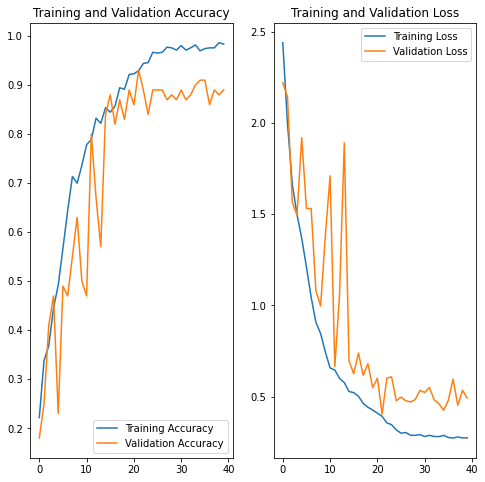

In [90]:
print(f"Training Accuracy: {100*history.history['categorical_accuracy'][39]:.2f}%")
print(f"Validation Accuracy: {100*history.history['val_categorical_accuracy'][39]:.2f}% \n")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion Experiment 10
- High Training Accuracy: After training for more epochs, the model has achieved a training accuracy of 99% and a validation accuracy of 89%.
- Model Stability: The model is stable.

# <b> End of Code </b>